In [1]:
import numpy as np
import xarray as xr
import xsimlab as xs
import matplotlib.pyplot as plt

from thermal import single_node

In [2]:
single_node

<xsimlab.Model (3 processes, 13 inputs)>
spacecraft
    A_inc         [in] space facing area
    A_rad         [in] earth facing area
    absorb        [in] spacecraft absorptivity
    emis          [in] spacecraft emissivity
    mass          [in] spacecraft mass
    spec_heat     [in] spacecraft specific heat
    Q_gen         [in] spacecraft power dissipation
orbit
    R             [in] body radius
    h             [in] orbit altitude
    tau           [in] orbit period
    case          [in] hot/ cold case
    beta          [in] beta, radians
thermal
    T_init        [in] initial temperature

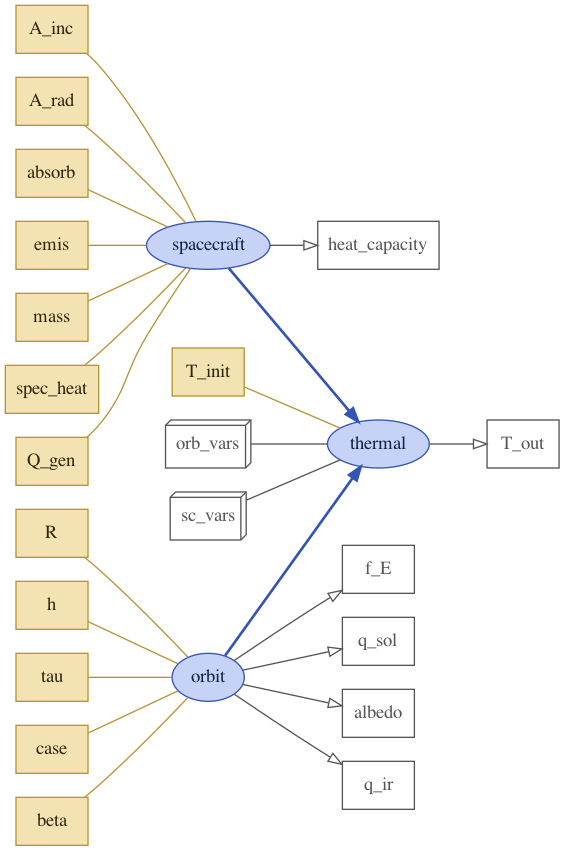

In [3]:
node_diag = single_node.visualize(show_variables='in')
node_diag

In [4]:
# %load_ext xsimlab.ipython

In [5]:
single_node.all_vars_dict

{'spacecraft': ['A_inc',
  'A_rad',
  'absorb',
  'emis',
  'mass',
  'spec_heat',
  'Q_gen',
  'heat_capacity'],
 'orbit': ['R', 'h', 'tau', 'case', 'beta', 'f_E', 'q_sol', 'albedo', 'q_ir'],
 'thermal': ['T_init', 'T_out', 'orb_vars', 'sc_vars']}

In [6]:
# %create_setup single_node --default --verbose

In [7]:
orbit_tau = 5400

ds_in = xs.create_setup(
    model=single_node,
    clocks={
        'time': np.linspace(0,6*orbit_tau, 2000)
    },
    input_vars={
        # space facing area
        'spacecraft__A_inc': 1.0,
        # earth facing area
        'spacecraft__A_rad': 1.0,
        # spacecraft absorptivity
        'spacecraft__absorb': 0.96,
        # spacecraft emissivity
        'spacecraft__emis': 0.9,
        # spacecraft mass
        'spacecraft__mass': 15.,
        # spacecraft specific heat
        'spacecraft__spec_heat': 897.,
        # spacecraft power dissipation
        'spacecraft__Q_gen': 20.,
        # body radius
        'orbit__R': 6378100.0,
        # orbit altitude
        'orbit__h': 525000.0,
        # orbit period
        'orbit__tau': 5400,
        # hot/ cold case
        'orbit__case': 'hot',
        # beta, radians
        'orbit__beta': 0,
        # initial temperature
        'thermal__T_init': 290.,
    },
    output_vars={
    'thermal__T_out': 'time'
    }
)


In [8]:
ds_in

<xarray.Dataset>
Dimensions:                (time: 2000)
Coordinates:
  * time                   (time) float64 0.0 16.21 32.42 ... 3.238e+04 3.24e+04
Data variables: (12/13)
    spacecraft__A_inc      float64 1.0
    spacecraft__A_rad      float64 1.0
    spacecraft__absorb     float64 0.96
    spacecraft__emis       float64 0.9
    spacecraft__mass       float64 15.0
    spacecraft__spec_heat  float64 897.0
    ...                     ...
    orbit__R               float64 6.378e+06
    orbit__h               float64 5.25e+05
    orbit__tau             int64 5400
    orbit__case            <U3 'hot'
    orbit__beta            int64 0
    thermal__T_init        float64 290.0

In [9]:
ds_out = ds_in.xsimlab.run(model=single_node)

AttributeError: 'SingleNode' object has no attribute 'f_E'

In [ ]:
ds_out.thermal__T_out.plot()

In [ ]:
ds_out.max()

In [ ]:
ds_in_batch = ds_in.xsimlab.update_vars(
   model=single_node,
   input_vars={'spacecraft__mass': ('batch', [1., 3., 5., 10, 15])}
)

ds_out_batch = ds_in_batch.xsimlab.run(model=single_node, batch_dim='batch')

In [ ]:
ds_out_batch.thermal__T_out.plot.line(hue='batch', row='batch', figsize=(16, 12), ylim=(260, 340))

In [ ]:
ds_out_batch

In [ ]:
ds_in_batch = ds_in.xsimlab.update_vars(
   model=single_node,
   input_vars={'spacecraft__Q_gen': ('batch', [5., 10., 15., 20., 45., 250.])}
)

ds_out_batch = ds_in_batch.xsimlab.run(model=single_node, batch_dim='batch')

In [ ]:
ds_out_batch.thermal__T_out.plot(hue='batch', figsize=(16, 12))
plt.grid()

In [ ]:
ds_in_batch = ds_in.xsimlab.update_vars(
   model=single_node,
   input_vars={'orbit__case': ('batch', ['hot', 'cold'])}
)

ds_out_batch = ds_in_batch.xsimlab.run(model=single_node, batch_dim='batch')

In [ ]:
ds_out_batch.thermal__T_out.plot.line(hue='batch', figsize=(16, 12))
plt.grid()

In [ ]:
D_sphere = 1

A_irs = np.pi*np.array([0.5*D_sphere, D_sphere, 1.5*D_sphere, 2*D_sphere])**2
A_sols = (4./3.)*np.pi*np.array([0.5*D_sphere, D_sphere, 1.5*D_sphere, 2*D_sphere])**3

ds_in_batch = ds_in.xsimlab.update_vars(
   model=single_node,
   input_vars={'spacecraft__Q_gen': 45.,
               'spacecraft__mass': 80.,
               'spacecraft__A_inc': ('batch', A_irs),
               'spacecraft__A_rad': ('batch', A_sols)}
)

ds_out_batch = ds_in_batch.xsimlab.run(model=single_node, batch_dim='batch')

# ds_out_batch.thermal__T_out.plot(row='batch', figsize=(12, 10))

# ds_out_batch.thermal__T_out.plot.line(hue='batch', row='batch', figsize=(16, 12), ylim=(260, 340))

In [ ]:
fg = ds_out_batch.thermal__T_out.plot.line(hue='batch', row='batch', figsize=(16, 12)) #, ylim=(220, 340))
title_vals = list(zip(A_sols, A_irs))

titles = ["Solar area: {:2} m^2 | IR area: {:2} m^2  | Mass = 80 kg  | Q_gen = 40W".format(val[0], val[1]) for val in title_vals]

for ax, title in zip(fg.axes.flat, titles):
    ax.set_title(title)
    ax.grid()
# fg.set_titles(["Solar area: {} m^2".format(A) for A in A_irs])


In [ ]:
ds_out_batch

In [ ]:
ds_in_batch = ds_in.xsimlab.update_vars(
   model=single_node,
   input_vars={
      'spacecraft__A_inc': 0.15,
      'spacecraft__A_rad': 0.15,
      'spacecraft__mass': 4,
      'spacecraft__Q_gen': 15,
      'orbit__case': 'cold',
      'orbit__beta': ('batch', [0, .2, .6, .9, 1.0, 1.1, 1.2, 1.4])}
)

ds_out_batch = ds_in_batch.xsimlab.run(model=single_node, batch_dim='batch')

In [ ]:
ds_out_batch.thermal__T_out.plot.imshow()

In [ ]:
# ds_out_batch.thermal__T_out

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(data=[go.Surface(
#     z=ds_out_batch.thermal__T_out.values,
#     x=ds_out_batch.time.values,
#     y=ds_out_batch.orbit__beta.values
#     )])

# fig.update_layout(scene = dict(
#                     xaxis_title='Time (seconds)',
#                     yaxis_title='Beta angle (radians)',
#                     zaxis_title='Temperature (Kelvin)'),
#                     width=700, height=500,
#                     margin=dict(r=20, b=20, l=20, t=10))
# fig.show()